In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from keras.applications.densenet import DenseNet169, DenseNet121
from keras.applications.mobilenet import MobileNet
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report
import lightgbm as lgb
import seaborn as sns

## loading the dataset

In [ ]:
SIZE = 224
images = []
images_labels = [] 

### importing each image and set the current directory name as its label 

In [ ]:
ext = ['png', 'jpg', 'jpeg'] 

for directory_path in glob.glob("PATH TO DATASET"):
    splited = directory_path.split("/")
    label = splited[-1]
    print(label)
    for e in ext:
      for img_path in glob.glob(os.path.join(directory_path, "*." + e)):
          #print(img_path)
           img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
           img = cv2.resize(img, (SIZE, SIZE))
           images.append(img)
           images_labels.append(label)

Pneumonia
No_findings
Covid-19


In [ ]:
images = np.array(images)
images_labels = np.array(images_labels)

In [ ]:
images.shape

(1125, 224, 224, 3)

In [ ]:
np.unique(images_labels)

array(['Covid-19', 'No_findings', 'Pneumonia'], dtype='<U11')

## Pre-processing

### label encoding

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(images_labels)
labels_encoded = le.transform(images_labels)

## Splitting dataset into train and test set


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=0)

### scaling train set and test set

In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

## Feature Extraction

### DenseNet169

In [ ]:
dense_model = DenseNet169(include_top=False, input_shape=(SIZE, SIZE, 3), pooling='avg')

51888128/51877672 [==============================] - 1s 0us/step


In [ ]:
dense_features = dense_model.predict(x_train)

In [ ]:
features = dense_features.reshape(dense_features.shape[0], -1)

In [ ]:
features.shape

(900, 1664)

### Mobilenet

In [ ]:
model_mobile = MobileNet(weights='imagenet',include_top=False, input_shape=(SIZE, SIZE, 3), pooling='avg')

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
mobile_features = model_mobile.predict(x_train)

In [ ]:
features_2 = mobile_features.reshape(mobile_features.shape[0], -1)

In [ ]:
features_2.shape

(900, 1024)

## Feature Combination

In [ ]:
combined_features = np.hstack((dense_features, mobile_features))

## lightgbm classifier

In [ ]:
params = {'learning_rate':0.24, 'n_iterations': 250, 'max_depth': 7, 'num_leaves': 105, 'n_estimators': 300, 'min_child_samples': 40 }


In [ ]:
lgb_classifier = lgb.LGBMClassifier(**params)

In [ ]:
lgb_classifier.fit(combined_features, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.24, max_depth=7,
               min_child_samples=40, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_iterations=250, n_jobs=-1, num_leaves=105,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

## predict test set

In [ ]:
X_test_dense_features = dense_model.predict(x_test)
X_test_dense_features = X_test_dense_features.reshape(X_test_dense_features.shape[0], -1)

In [ ]:
X_test_mobile_features = model_mobile.predict(x_test)
X_test_mobile_features = X_test_mobile_features.reshape(X_test_mobile_features.shape[0], -1)

In [ ]:
combined_test_features = np.hstack((X_test_dense_features, X_test_mobile_features))

In [ ]:
prediction = lgb_classifier.predict(combined_test_features)
# prediction = le.inverse_transform(prediction)

## accuracy score

In [ ]:
accuracy = accuracy_score(y_test, prediction)
accuracy

0.9111111111111111

## Performance checking

In [ ]:
cm = confusion_matrix(y_test, prediction)

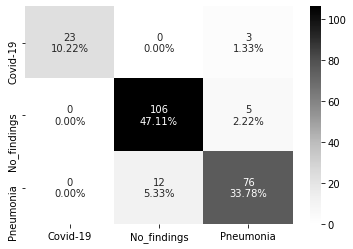

In [ ]:
categories = ['Covid-19', 'No_findings', 'Pneumonia']
counts = ['{0:0.0f}'.format(value) for value in
          cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                      cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(counts, group_percentages)]
labels = np.asarray(labels).reshape(3, 3)


sns_plot = sns.heatmap(cm, annot=labels, fmt='', cmap='Greys',xticklabels=categories, yticklabels=categories)

In [ ]:
def confusion_metrics(cm, class_name):
  report = classification_report(y_test, prediction, target_names=categories, output_dict=True)


  if class_name == 'Covid-19':
      sensitivity = cm[0,0]/sum(cm[0,:])
      specificity = (cm[1,1]+cm[2,2])/(cm[1,0]+cm[2,0]+cm[1,1]+cm[2,2])
      precision = report[class_name]['precision']
      f1 = report[class_name]['f1-score']
  elif class_name == 'No_findings':
      sensitivity = cm[1,1]/sum(cm[1,:])
      specificity = (cm[0,0]+cm[2,2])/(cm[0,1]+cm[2,1]+cm[0,0]+cm[2,2])
      precision = report[class_name]['precision']
      f1 = report[class_name]['f1-score']
  elif class_name == 'Pneumonia':
      sensitivity = cm[2,2]/sum(cm[2,:])
      specificity = (cm[0,0]+cm[1,1])/(cm[0,2]+cm[1,2]+cm[0,0]+cm[1,1])
      precision = report[class_name]['precision']
      f1 = report[class_name]['f1-score']


  result = {'Sensitivity': sensitivity*100, 'Specificity': specificity *
              100, 'Precision': precision*100, 'F1-Score': f1*100}
  return result

In [ ]:
performance = pd.DataFrame(
    columns=['Class', 'Sensitivity', 'Specificity', 'Precision', 'F1-Score', 'Accuracy'])
performance

,Class,Sensitivity,Specificity,Precision,F1-Score,Accuracy


In [ ]:
for c in categories:
  data = {**{'Class': f'{c}'}, **confusion_metrics(cm, c), **{'Accuracy': accuracy*100 }}
  performance = performance.append(data, ignore_index=True)


In [ ]:
performance

,Class,Sensitivity,Specificity,Precision,F1-Score,Accuracy
0,Covid-19,88.461538,100.000000,100.000000,93.877551,91.111111
1,No_findings,95.495495,89.189189,89.830508,92.576419,91.111111
2,Pneumonia,86.363636,94.160584,90.476190,88.372093,91.111111
